In [29]:
import numpy as np
import mnist_reader  # 假设这是从fashion-mnist的utils目录导入的
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#pip install scikit-learn 
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size,reg_lambda=0.01, activation='tanh'):
        #输入大小即为输入特征的大小
        #隐藏层大小即为中间隐藏层的神经节点个数
        #输出大小跟任务类别有关，一般为n分类任务，即输出n，如果是二分类或者回归则为1
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        #对权重矩阵进行正态初始化，刚开始先保证初始化值小点，防止梯度消失或者更新慢
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.activation = activation
        self.best_weights = None
        self.best_performance = float('inf')
        self.reg_lambda=reg_lambda

    def relu(self, z):
        return np.maximum(0, z)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def tanh(self, z):
        return np.tanh(z)

    def leaky_relu(self, z, alpha=0.01):
        return np.where(z > 0, z, z * alpha)
    
    def elu(self, z, alpha=1.0):
        return np.where(z > 0, z, alpha * (np.exp(z) - 1))

    def swish(self, z, beta=1.0):
        return z * self.sigmoid(beta * z)
    #这个函数
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        #进行点乘操作
        self.z1 = np.dot(X, self.W1) + self.b1
        if self.activation == 'relu':
            self.a1 = self.relu(self.z1)
        elif self.activation == 'sigmoid':
            self.a1 = self.sigmoid(self.z1)
        elif self.activation == 'tanh':
            self.a1 = self.tanh(self.z1)
        elif self.activation == 'leaky_relu':
            self.a1 = self.leaky_relu(self.z1)
        elif self.activation == 'elu':
            self.a1 = self.elu(self.z1)
        elif self.activation == 'swish':
            self.a1 = self.swish(self.z1)
        else:
            raise ValueError("Unsupported activation function")
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def one_hot_encode(self,y,num_classes):
        """将一维类别索引数组转换为独热编码格式."""
        y_encoded = np.zeros((y.size, num_classes))
        y_encoded[np.arange(y.size), y] = 1
        return y_encoded
    #反向传播
    #随机梯度下降:SGD优化器
    #正则化参数reg_lambda
    def backward(self, X, y, learning_rate=0.01):
        m = y.shape[0]
        #计算输出层的误差
        #有问题
        grad_z2 = self.a2 - y
        grad_W2 = np.dot(self.a1.T, grad_z2) / m + self.reg_lambda * self.W2
        grad_b2 = np.sum(grad_z2, axis=0, keepdims=True) / m

        grad_a1 = np.dot(grad_z2, self.W2.T)
        if self.activation == 'relu':
            grad_z1 = grad_a1 * (self.z1 > 0)
        elif self.activation == 'sigmoid':
            grad_z1 = grad_a1 * self.a1 * (1 - self.a1)
        elif self.activation == 'tanh':
            grad_z1 = grad_a1 * (1 - np.square(self.tanh(self.z1)))
        elif self.activation == 'leaky_relu':
            grad_z1 = grad_a1 * (self.z1 > 0) + grad_a1 * 0.01 * (self.z1 <= 0)
        elif self.activation == 'elu':
            alpha = 1.0  # ELU alpha parameter
            grad_z1 = grad_a1 * ((self.z1 > 0) + (self.z1 <= 0) * alpha * np.exp(self.z1))
        elif self.activation == 'swish':
            beta = 1.0  # Swish beta parameter
            sigmoid_beta_z1 = self.sigmoid(beta * self.z1)
            grad_z1 = grad_a1 * (self.swish(self.z1) + sigmoid_beta_z1 * (1 - self.swish(self.z1)))
        else:
            raise ValueError("Unsupported activation function")
        grad_W1 = np.dot(X.T, grad_z1) / m + self.reg_lambda * self.W1
        grad_b1 = np.sum(grad_z1, axis=0, keepdims=True) / m

        self.W1 -= learning_rate * grad_W1
        self.b1 -= learning_rate * grad_b1
        self.W2 -= learning_rate * grad_W2
        self.b2 -= learning_rate * grad_b2
    #加载最好模型
    def load_best_weights(self):
        if self.best_weights is not None:
            self.W1, self.b1, self.W2, self.b2 = self.best_weights
    #预测label
    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)
    #计算损失
    def compute_loss(self,y_true, y_pred):
        m = y_true.shape[0]
        log_probs = -np.log(y_pred[range(m), y_true])
        loss = np.sum(log_probs) / m + self.reg_lambda / 2 * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        return loss
#计算交叉熵损失和L2正则化损失
#正则化是为了惩罚大的权重值，防止模型过拟合
#正则化前面的系数/2是为了求导方便
#np.square不改变模型的维度
#np.sum计算所有元素的平方和
def get_accuracy(y_true, y_pred):
    #print(y_true)
    #print(np.argmax(y_pred, axis=1))
    return np.mean(y_true == np.argmax(y_pred, axis=1))
#训练函数
#可视化每个epoch的训练、验证loss、验证accuracy
def train(X_train, y_train, X_val, y_val,epochs=50, batch_size=100, learning_rate=0.1, hidden_size=100,lr_decay=0.5,reg_lambda=0.01):
    n_train, n_features = X_train.shape
    n_classes = np.max(y_train) + 1
    model = NeuralNetwork(n_features, hidden_size, n_classes,reg_lambda)
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(epochs):
        for start_idx in range(0, n_train, batch_size):
            end_idx = min(start_idx + batch_size, n_train)
            batch_x = X_train[start_idx:end_idx]
            batch_y = y_train[start_idx:end_idx]
            # Forward + backward
            output = model.forward(batch_x)
            #独热编码
            #print(batch_y)
            batch_y_one=model.one_hot_encode(batch_y,10)
            model.backward(batch_x, batch_y_one, learning_rate)
        #每个epoch后调整学习率
        learning_rate *= lr_decay
        #计算每个epoch的损失
        y_train_pred=model.forward(X_train)
        loss = model.compute_loss(y_train, y_train_pred)
        # 每个epoch下的验证集性能
        y_val_pred = model.forward(X_val)
        val_loss = model.compute_loss(y_val, y_val_pred)
        val_accuracy = get_accuracy(y_val, y_val_pred)
        # 如果在验证集上表现更好，保存权重
        if val_loss < model.best_performance:
            model.best_performance = val_loss
            model.best_weights = (copy.deepcopy(model.W1), copy.deepcopy(model.b1),
                                copy.deepcopy(model.W2), copy.deepcopy(model.b2))
        # Store metrics
        train_losses.append(loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch + 1}, Loss: {loss}, Val Loss: {val_loss}")

    return model,train_losses,val_losses,val_accuracies
def test(model, X_test, y_test):
    predictions = model.forward(X_test)
    print(predictions)
    #每行找最大值
    predicted_labels = np.argmax(predictions, axis=1)
    print(predicted_labels)
    accuracy = np.mean(predicted_labels == y_test)
    return accuracy

In [27]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### batch size比较分析

46.39911036207336
Epoch 1, Loss: 46.31365653587045, Val Loss: 46.39911036207336
15.544201019663399
Epoch 2, Loss: 15.495535517905903, Val Loss: 15.544201019663399
3.6887411100834755
Epoch 3, Loss: 3.6908995801826316, Val Loss: 3.6887411100834755
1.1382133202105764
Epoch 4, Loss: 1.1280635455663433, Val Loss: 1.1382133202105764
0.7664629653785304
Epoch 5, Loss: 0.7532183490239287, Val Loss: 0.7664629653785304
0.6394521112750653
Epoch 6, Loss: 0.6292495047982767, Val Loss: 0.6394521112750653
0.5472239740971394
Epoch 7, Loss: 0.5368964497940246, Val Loss: 0.5472239740971394
0.49401592092628793
Epoch 8, Loss: 0.48233871593195193, Val Loss: 0.49401592092628793
0.4586089101757827
Epoch 9, Loss: 0.4422143173250304, Val Loss: 0.4586089101757827
0.4450873966510439
Epoch 10, Loss: 0.42570393283581753, Val Loss: 0.4450873966510439


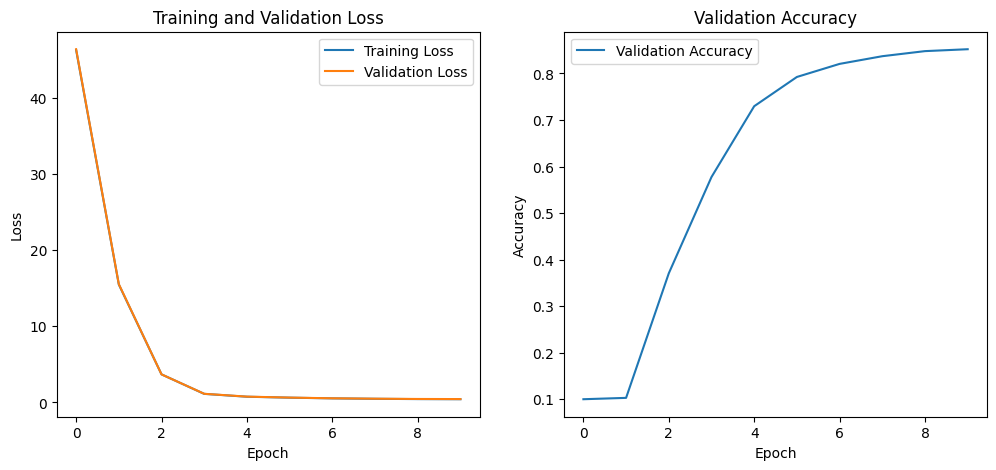

[[1.13584846e-04 4.93890521e-04 1.16994982e-03 ... 1.22436811e-01
  6.56372621e-03 7.92859221e-01]
 [8.71054067e-03 1.95835916e-03 7.81677313e-01 ... 3.23622271e-04
  3.55222509e-03 8.18410912e-04]
 [3.40996148e-03 9.82387232e-01 1.44253379e-03 ... 1.18483733e-03
  7.74429382e-05 4.84190155e-04]
 ...
 [2.10966820e-02 1.80905685e-04 1.22969087e-03 ... 1.86822152e-03
  9.16716135e-01 1.46819237e-03]
 [1.87746140e-03 9.78917377e-01 1.07227495e-03 ... 1.28983757e-03
  6.85384629e-05 9.45832445e-04]
 [6.72702438e-06 9.13688375e-05 3.30203251e-04 ... 1.90072596e-02
  2.09115644e-03 1.44385117e-03]]
[9 2 1 ... 8 1 5]
Test Accuracy: 0.84
41.4964124422232
Epoch 1, Loss: 41.634399979790324, Val Loss: 41.4964124422232
11.472288964517901
Epoch 2, Loss: 11.469513774464655, Val Loss: 11.472288964517901
2.349741878940049
Epoch 3, Loss: 2.355764780141088, Val Loss: 2.349741878940049
0.984932377046818
Epoch 4, Loss: 0.9721569586279124, Val Loss: 0.984932377046818
0.7414321004971627
Epoch 5, Loss: 0.731

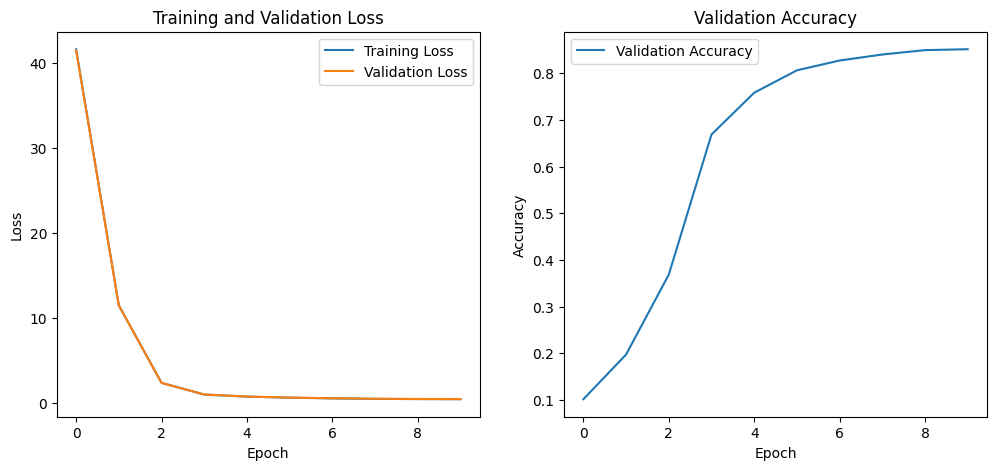

[[4.53283051e-04 6.10676679e-04 2.12954345e-03 ... 1.19706119e-01
  6.09059239e-03 7.69289239e-01]
 [4.91862341e-03 1.83030468e-03 8.80460155e-01 ... 2.92957878e-04
  1.88258171e-03 6.61052693e-04]
 [3.19122608e-03 9.86282935e-01 1.27154647e-03 ... 8.07612358e-04
  4.28118077e-05 3.85198178e-04]
 ...
 [1.49011760e-02 3.22818079e-04 2.25732857e-03 ... 1.99790389e-03
  8.90930028e-01 1.17072064e-03]
 [1.96877048e-03 9.72571719e-01 1.61096067e-03 ... 9.69241556e-04
  6.17595298e-05 1.15293712e-03]
 [2.92359951e-05 6.99424587e-05 4.09511880e-04 ... 3.28112216e-02
  5.73959093e-03 1.78588672e-03]]
[9 2 1 ... 8 1 5]
Test Accuracy: 0.84
35.97024334413689
Epoch 1, Loss: 36.209701140835044, Val Loss: 35.97024334413689
10.227229430127743
Epoch 2, Loss: 10.223458268171983, Val Loss: 10.227229430127743
2.3101008793118565
Epoch 3, Loss: 2.3092731527309125, Val Loss: 2.3101008793118565
1.0534440578575348
Epoch 4, Loss: 1.040697827427067, Val Loss: 1.0534440578575348
0.735071526497625
Epoch 5, Loss: 

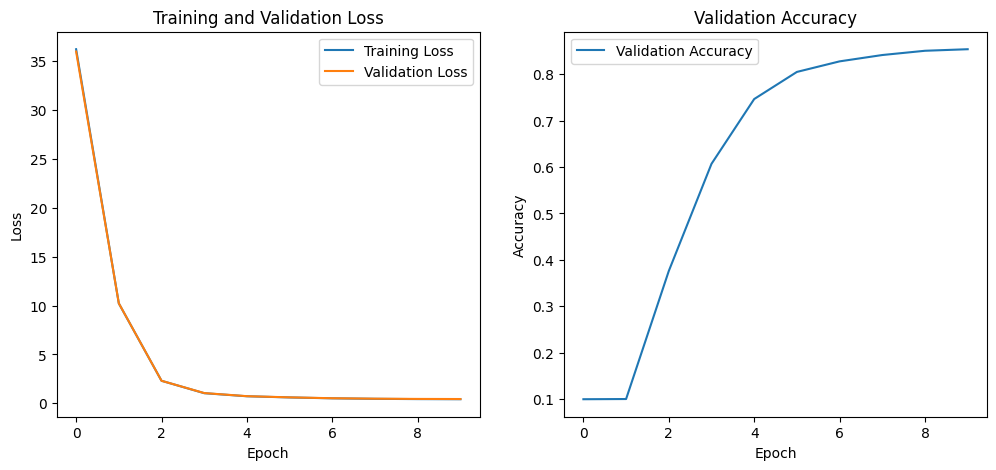

[[1.96435339e-04 1.06434242e-03 1.56948292e-03 ... 1.47439812e-01
  5.08720442e-03 7.59456841e-01]
 [6.51123718e-03 2.03142474e-03 8.79091099e-01 ... 3.91692453e-04
  2.75331761e-03 8.18786971e-04]
 [3.03004796e-03 9.85203816e-01 1.38068125e-03 ... 1.06562181e-03
  6.59427558e-05 5.57579019e-04]
 ...
 [3.64601925e-02 4.02318600e-04 1.27096180e-03 ... 2.36444886e-03
  8.86048442e-01 2.17641557e-03]
 [2.07061215e-03 9.79113359e-01 1.34291232e-03 ... 1.33891426e-03
  6.01004316e-05 8.39076744e-04]
 [1.31864926e-05 9.19185440e-05 1.09231106e-03 ... 2.66266405e-02
  4.66122375e-03 3.61103682e-03]]
[9 2 1 ... 8 1 5]
Test Accuracy: 0.84
31.095701832139387
Epoch 1, Loss: 30.942220079336817, Val Loss: 31.095701832139387
9.102999337042982
Epoch 2, Loss: 9.041068412432095, Val Loss: 9.102999337042982
2.335977700321638
Epoch 3, Loss: 2.3177265460097978, Val Loss: 2.335977700321638
0.9234346498686369
Epoch 4, Loss: 0.9085407589919643, Val Loss: 0.9234346498686369
0.7101742454375624
Epoch 5, Loss: 0

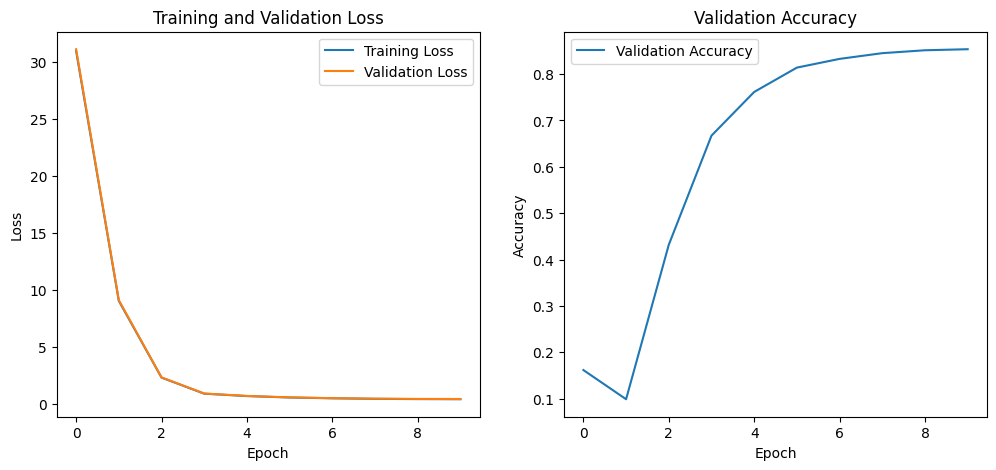

[[5.18657242e-04 1.18251503e-03 1.98296761e-03 ... 1.31887451e-01
  6.88529268e-03 7.65118618e-01]
 [9.25032500e-03 1.50601179e-03 8.32060079e-01 ... 2.26250161e-04
  4.60326936e-03 7.37160928e-04]
 [3.53426092e-03 9.84478853e-01 1.04050701e-03 ... 1.06344397e-03
  6.24792259e-05 4.84961329e-04]
 ...
 [1.72560686e-02 2.91953030e-04 1.31247294e-03 ... 2.14805203e-03
  8.95764284e-01 1.50510621e-03]
 [2.34232341e-03 9.81248396e-01 9.77558443e-04 ... 9.46641627e-04
  4.50167400e-05 9.49792403e-04]
 [2.21519614e-05 9.79639403e-05 7.92420091e-04 ... 2.87080931e-02
  5.33702851e-03 2.25063114e-03]]
[9 2 1 ... 8 1 5]
Test Accuracy: 0.84
25.04625892307797
Epoch 1, Loss: 24.967174593150222, Val Loss: 25.04625892307797
8.619183336972561
Epoch 2, Loss: 8.588887663222405, Val Loss: 8.619183336972561
1.5900447946076184
Epoch 3, Loss: 1.5800757775576955, Val Loss: 1.5900447946076184
0.9580498197725225
Epoch 4, Loss: 0.9430110796845361, Val Loss: 0.9580498197725225
0.7178939242581117
Epoch 5, Loss: 0

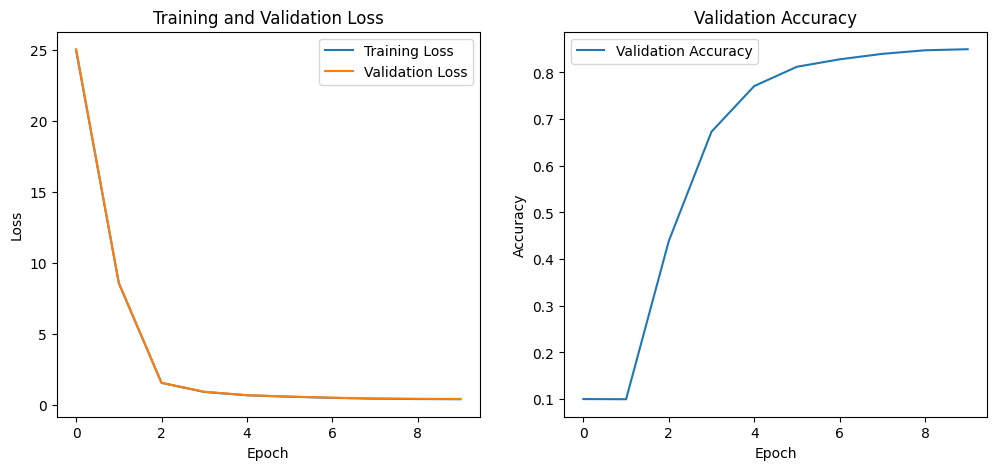

[[3.79690123e-04 1.79590727e-03 2.12544073e-03 ... 9.87348593e-02
  6.66184643e-03 7.61056979e-01]
 [1.06693591e-02 1.82212462e-03 7.47743454e-01 ... 4.86079131e-04
  5.31763269e-03 1.02044436e-03]
 [3.34914402e-03 9.82639326e-01 1.37325515e-03 ... 1.26873732e-03
  5.26905595e-05 6.71118156e-04]
 ...
 [1.89239270e-02 7.65189585e-05 1.11947913e-03 ... 1.37950039e-03
  9.29639011e-01 1.14691732e-03]
 [3.22322680e-03 9.71916067e-01 1.39923156e-03 ... 1.26803800e-03
  5.65315840e-05 1.46612666e-03]
 [3.69845117e-05 2.00371227e-04 1.11378411e-03 ... 3.35292432e-02
  4.94924933e-03 2.50145064e-03]]
[9 2 1 ... 8 1 5]
Test Accuracy: 0.84


In [19]:
all_train_losses,all_val_losses,all_val_accuracies,all_accuracy=[],[],[],[]
batch_sizes=list(range(50,100,10))
for batch_size in batch_sizes:
    model,train_losses,val_losses,val_accuracies = train(X_train, y_train, X_val, y_val, epochs=10, batch_size=batch_size, learning_rate=0.1, hidden_size=1000)
    accuracy = test(model, X_test, y_test)
    all_accuracy.append(accuracy)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_val_accuracies.append(val_accuracies)
    print(f'Test Accuracy: {accuracy:.2f}')


[0.8427, 0.8442, 0.8448, 0.8438, 0.8415]


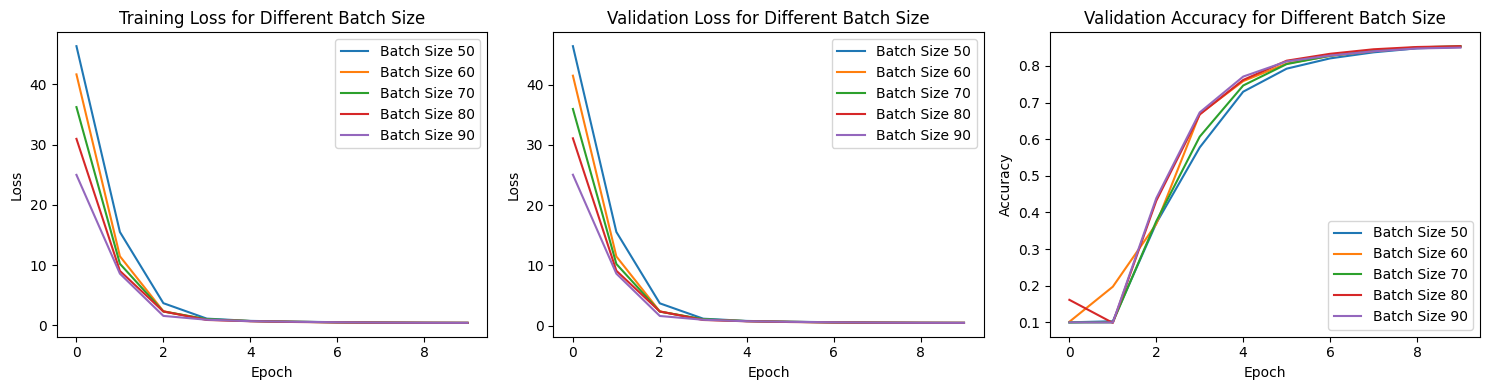

In [20]:
#可视化
print(all_accuracy)
sizes=list(range(0,len(all_accuracy)))
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3, figsize=(15, 4))
for i,train_loss,val_loss,val_acc in zip(sizes,all_train_losses,all_val_losses,all_val_accuracies):
    ax1.plot(train_loss, label=f'Batch Size {batch_sizes[i]}')
    ax2.plot(val_loss, label=f'Batch Size {batch_sizes[i]}')
    ax3.plot(val_acc, label=f'Batch Size {batch_sizes[i]}')
    #ax4.plot(acc, label=f'Batch Size {batch_sizes[i]}')
    
    
    
# 设置第一个子图的图例、标题和标签
ax1.legend()
ax1.set_title('Training Loss for Different Batch Size')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')


# 设置第二个子图的图例、标题和标签
ax2.legend()
ax2.set_title('Validation Loss for Different Batch Size')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

# 设置第三个子图的图例、标题和标签
ax3.legend()
ax3.set_title('Validation Accuracy for Different Batch Size')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')


# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

### learning_rate比较分析

In [32]:
import numpy as np

all_train_losses,all_val_losses,all_val_accuracies,all_accuracy=[],[],[],[]
learning_rates = list(np.arange(0.001, 0.01, 0.005))
for learning_rate in learning_rates:
    model,train_losses,val_losses,val_accuracies = train(X_train, y_train, X_val, y_val, epochs=10, batch_size=70, learning_rate=learning_rate, hidden_size=1000)
    accuracy = test(model, X_test, y_test)
    all_accuracy.append(accuracy)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_val_accuracies.append(val_accuracies)
    print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1, Loss: 0.9754357318049869, Val Loss: 0.9899988677541078
Epoch 2, Loss: 0.9044661804383957, Val Loss: 0.9217998161938834
Epoch 3, Loss: 0.8774746484484324, Val Loss: 0.8986047817700691
Epoch 4, Loss: 0.8648102537303322, Val Loss: 0.8880452242897613
Epoch 5, Loss: 0.8583191031211596, Val Loss: 0.8828545837311546
Epoch 6, Loss: 0.8550306865535715, Val Loss: 0.8807245062083079
Epoch 7, Loss: 0.8533688430612965, Val Loss: 0.879662932566408
Epoch 8, Loss: 0.8525933200305107, Val Loss: 0.8791565915986586
Epoch 9, Loss: 0.8522284889460126, Val Loss: 0.8789147692978071
Epoch 10, Loss: 0.8520516320470091, Val Loss: 0.8787961976170534
[[6.51172140e-04 5.49178499e-04 1.18962616e-03 ... 1.84846557e-01
  1.54808975e-02 6.81733745e-01]
 [6.74797932e-03 1.07403828e-03 7.89642886e-01 ... 3.26344685e-04
  4.58250351e-03 1.01635187e-03]
 [1.99172789e-03 9.91034928e-01 5.26792160e-04 ... 1.66519224e-04
  1.22497399e-04 1.04041957e-04]
 ...
 [7.07401983e-02 1.94775067e-03 6.51846878e-03 ... 3.44590

[0.8272, 0.8426]


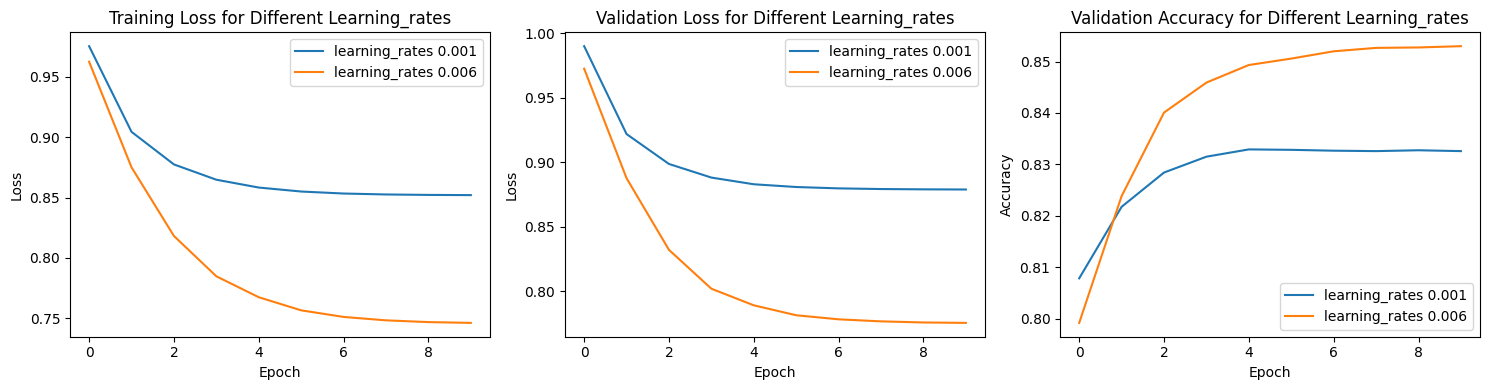

In [34]:
#可视化
print(all_accuracy)
sizes=list(range(0,len(all_accuracy)))
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3, figsize=(15, 4))
for i,train_loss,val_loss,val_acc in zip(sizes,all_train_losses,all_val_losses,all_val_accuracies):
    ax1.plot(train_loss, label=f'learning_rates {learning_rates[i]:.3f}')
    ax2.plot(val_loss, label=f'learning_rates {learning_rates[i]:.3f}')
    ax3.plot(val_acc, label=f'learning_rates {learning_rates[i]:.3f}')
    #ax4.plot(acc, label=f'Batch Size {batch_sizes[i]}')
    
    
    
# 设置第一个子图的图例、标题和标签
ax1.legend()
ax1.set_title('Training Loss for Different Learning_rates')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')


# 设置第二个子图的图例、标题和标签
ax2.legend()
ax2.set_title('Validation Loss for Different Learning_rates')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

# 设置第三个子图的图例、标题和标签
ax3.legend()
ax3.set_title('Validation Accuracy for Different Learning_rates')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')


# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

### hidden_size比较分析

In [37]:
import numpy as np

all_train_losses,all_val_losses,all_val_accuracies,all_accuracy=[],[],[],[]
hidden_sizes = list(np.arange(1000, 2000, 200))
for hidden_size in hidden_sizes:
    model,train_losses,val_losses,val_accuracies = train(X_train, y_train, X_val, y_val, epochs=10, batch_size=70, learning_rate=0.01, hidden_size=hidden_size)
    accuracy = test(model, X_test, y_test)
    all_accuracy.append(accuracy)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_val_accuracies.append(val_accuracies)
    print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1, Loss: 1.071070098783504, Val Loss: 1.0834561311910045
Epoch 2, Loss: 0.9199570061023703, Val Loss: 0.9299736444713835
Epoch 3, Loss: 0.8495242999936907, Val Loss: 0.8615577971949591
Epoch 4, Loss: 0.8109559129065489, Val Loss: 0.8233160024538022
Epoch 5, Loss: 0.7843702007858069, Val Loss: 0.8004494985539936
Epoch 6, Loss: 0.768771580642464, Val Loss: 0.7877806745824971
Epoch 7, Loss: 0.7604290514097378, Val Loss: 0.781703935670048
Epoch 8, Loss: 0.756337263106039, Val Loss: 0.7795017457489049
Epoch 9, Loss: 0.7538459197403773, Val Loss: 0.7785857003659793
Epoch 10, Loss: 0.7526668904152725, Val Loss: 0.7781985763981896
[[3.68249003e-05 6.78805280e-05 2.57857354e-04 ... 1.45151048e-01
  2.13709541e-03 7.14127339e-01]
 [4.27095901e-03 1.39599307e-03 8.96756843e-01 ... 1.11637943e-04
  1.09317862e-03 1.47449595e-04]
 [3.41857333e-04 9.96615332e-01 2.44514085e-04 ... 3.44622857e-05
  5.48887935e-06 6.26634572e-06]
 ...
 [1.59051846e-02 1.09993360e-04 2.30524912e-04 ... 7.08438374

[0.838, 0.8425, 0.8456, 0.8479, 0.8469]


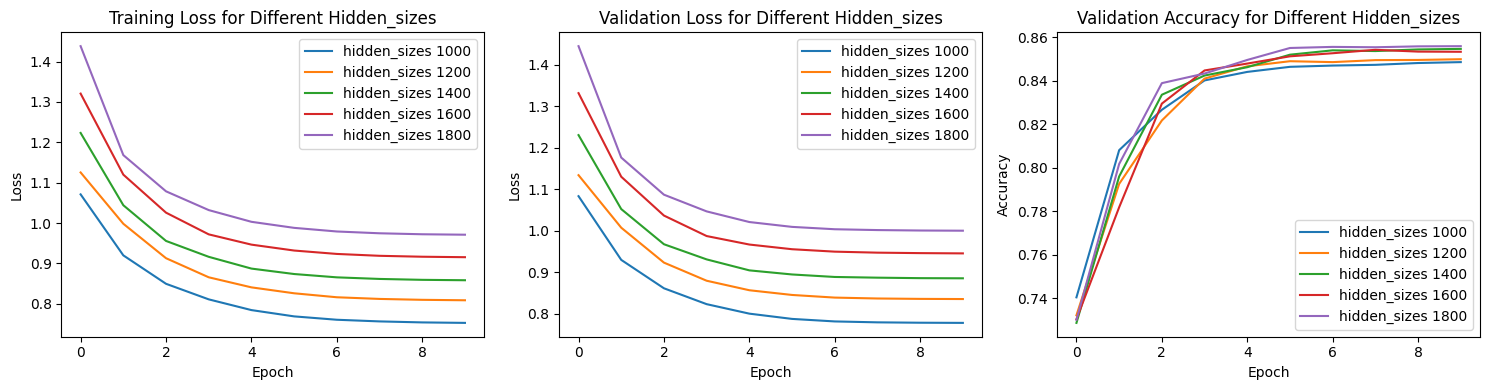

In [38]:
#可视化
print(all_accuracy)
sizes=list(range(0,len(all_accuracy)))
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3, figsize=(15, 4))
for i,train_loss,val_loss,val_acc in zip(sizes,all_train_losses,all_val_losses,all_val_accuracies):
    ax1.plot(train_loss, label=f'hidden_sizes {hidden_sizes[i]}')
    ax2.plot(val_loss, label=f'hidden_sizes {hidden_sizes[i]}')
    ax3.plot(val_acc, label=f'hidden_sizes {hidden_sizes[i]}')
    #ax4.plot(acc, label=f'Batch Size {batch_sizes[i]}')
    
    
    
# 设置第一个子图的图例、标题和标签
ax1.legend()
ax1.set_title('Training Loss for Different Hidden_sizes')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')


# 设置第二个子图的图例、标题和标签
ax2.legend()
ax2.set_title('Validation Loss for Different Hidden_sizes')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

# 设置第三个子图的图例、标题和标签
ax3.legend()
ax3.set_title('Validation Accuracy for Different Hidden_sizes')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')


# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

### lr_decay学习下降率比较分析

In [41]:
import numpy as np

all_train_losses,all_val_losses,all_val_accuracies,all_accuracy=[],[],[],[]
lr_decays = list(np.arange(0.5, 1, 0.1))
for lr_decay in lr_decays:
    model,train_losses,val_losses,val_accuracies = train(X_train, y_train, X_val, y_val, epochs=10, batch_size=80, learning_rate=0.01, hidden_size=1600,lr_decay=lr_decay)
    accuracy = test(model, X_test, y_test)
    all_accuracy.append(accuracy)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_val_accuracies.append(val_accuracies)
    print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1, Loss: 1.2464892157172671, Val Loss: 1.2551072799669356
Epoch 2, Loss: 1.081225588476316, Val Loss: 1.0892132595579618
Epoch 3, Loss: 1.0170779893149429, Val Loss: 1.0296651430114376
Epoch 4, Loss: 0.9727506740111171, Val Loss: 0.9902772175369287
Epoch 5, Loss: 0.9488674167181408, Val Loss: 0.9702949382822812
Epoch 6, Loss: 0.9352251753304417, Val Loss: 0.9585462465048986
Epoch 7, Loss: 0.9281138079397702, Val Loss: 0.9537057935909409
Epoch 8, Loss: 0.9234843296541482, Val Loss: 0.9513139763169594
Epoch 9, Loss: 0.9211677346558955, Val Loss: 0.9503702325838246
Epoch 10, Loss: 0.9201099136629713, Val Loss: 0.9499556714069259
[[6.33939862e-06 1.48870698e-05 8.22846960e-05 ... 1.45029677e-01
  2.46548179e-03 8.12145508e-01]
 [5.51716748e-03 1.26256428e-03 8.35190764e-01 ... 1.00990300e-04
  1.99547930e-03 1.84000686e-04]
 [6.33246273e-04 9.97901929e-01 1.10240000e-04 ... 2.48496933e-05
  1.34608136e-05 5.68261978e-06]
 ...
 [1.07667505e-02 2.18855402e-05 1.55554034e-04 ... 4.55044

[0.8453, 0.8511, 0.852, 0.8463, 0.8185]


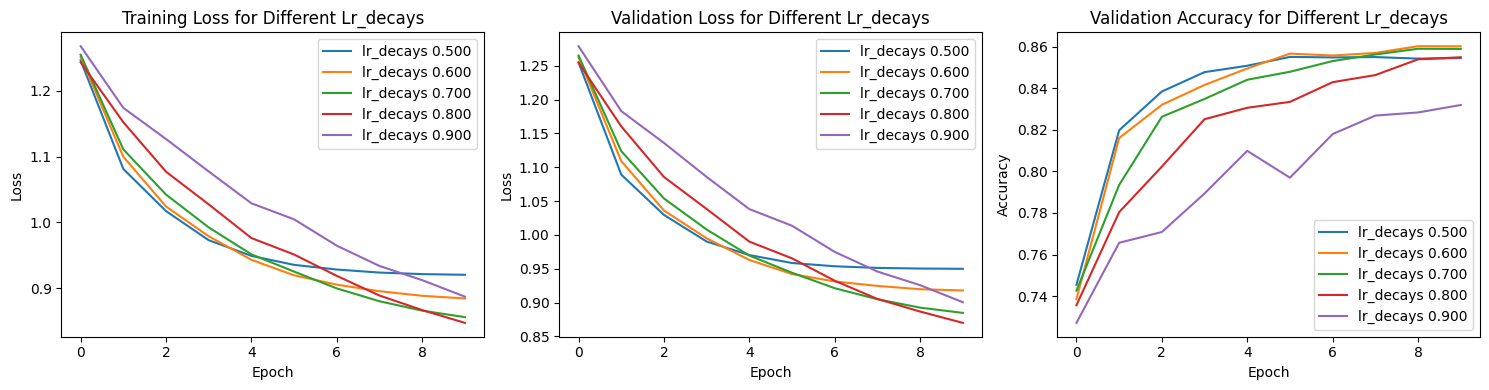

In [43]:
#可视化
print(all_accuracy)
sizes=list(range(0,len(all_accuracy)))
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3, figsize=(15, 4))
for i,train_loss,val_loss,val_acc in zip(sizes,all_train_losses,all_val_losses,all_val_accuracies):
    ax1.plot(train_loss, label=f'lr_decays {lr_decays[i]:.3f}')
    ax2.plot(val_loss, label=f'lr_decays {lr_decays[i]:.3f}')
    ax3.plot(val_acc, label=f'lr_decays {lr_decays[i]:.3f}')
    #ax4.plot(acc, label=f'Batch Size {batch_sizes[i]}')
    
# 设置第一个子图的图例、标题和标签
ax1.legend()
ax1.set_title('Training Loss for Different Lr_decays')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')


# 设置第二个子图的图例、标题和标签
ax2.legend()
ax2.set_title('Validation Loss for Different Lr_decays')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

# 设置第三个子图的图例、标题和标签
ax3.legend()
ax3.set_title('Validation Accuracy for Different Lr_decays')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')


# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

### reg_lambda L2正则系数比较分析


In [46]:
import numpy as np

all_train_losses,all_val_losses,all_val_accuracies,all_accuracy=[],[],[],[]
reg_lambdas = list(np.arange(0.1, 0.6, 0.1))
for reg_lambda in reg_lambdas:
    model,train_losses,val_losses,val_accuracies = train(X_train, y_train, X_val, y_val, epochs=10, batch_size=80, learning_rate=0.01, hidden_size=1600,reg_lambda=reg_lambda)
    accuracy = test(model, X_test, y_test)
    all_accuracy.append(accuracy)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_val_accuracies.append(val_accuracies)
    print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1, Loss: 2.884889680843698, Val Loss: 2.894989407669739
Epoch 2, Loss: 1.8111341521592084, Val Loss: 1.8206054806150285
Epoch 3, Loss: 1.4422389673363165, Val Loss: 1.4518123338021258
Epoch 4, Loss: 1.2758456753873118, Val Loss: 1.290298070939444
Epoch 5, Loss: 1.1921495883518671, Val Loss: 1.2111539021944806
Epoch 6, Loss: 1.1515553846577078, Val Loss: 1.1735376777125222
Epoch 7, Loss: 1.130927381421259, Val Loss: 1.1555888739213531
Epoch 8, Loss: 1.1199500049365012, Val Loss: 1.1459876386433576
Epoch 9, Loss: 1.114344862717259, Val Loss: 1.1414462155709775
Epoch 10, Loss: 1.1115912752903214, Val Loss: 1.1393169182940381
[[7.93931794e-05 1.63552916e-04 5.40581318e-04 ... 7.77170511e-02
  2.25812678e-03 8.76373996e-01]
 [4.39164505e-03 1.02047871e-03 8.69498008e-01 ... 1.75866514e-04
  1.49209495e-03 4.35430563e-04]
 [1.63926751e-03 9.93389144e-01 7.61627807e-04 ... 2.46195414e-04
  1.28277775e-04 1.08306215e-04]
 ...
 [1.79170459e-02 2.90155554e-04 1.00738508e-03 ... 1.70590474e

[0.8551, 0.8565, 0.8591, 0.8566, 0.8565]


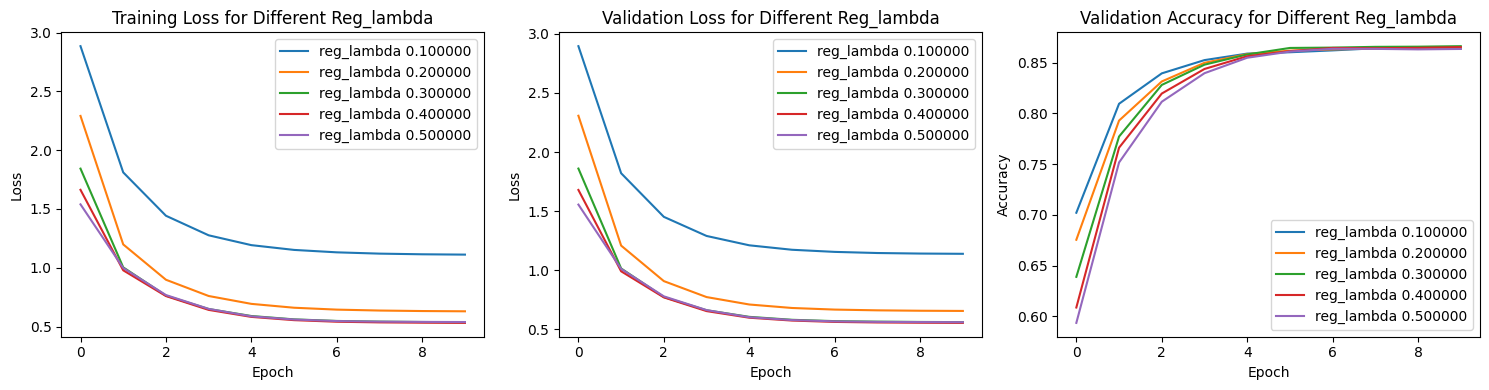

In [48]:
#可视化
print(all_accuracy)
sizes=list(range(0,len(all_accuracy)))
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3, figsize=(15, 4))
for i,train_loss,val_loss,val_acc in zip(sizes,all_train_losses,all_val_losses,all_val_accuracies):
    ax1.plot(train_loss, label=f'reg_lambda {reg_lambdas[i]:3f}')
    ax2.plot(val_loss, label=f'reg_lambda {reg_lambdas[i]:3f}')
    ax3.plot(val_acc, label=f'reg_lambda {reg_lambdas[i]:3f}')
    #ax4.plot(acc, label=f'Batch Size {batch_sizes[i]}')
    
# 设置第一个子图的图例、标题和标签
ax1.legend()
ax1.set_title('Training Loss for Different Reg_lambda')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')


# 设置第二个子图的图例、标题和标签
ax2.legend()
ax2.set_title('Validation Loss for Different Reg_lambda')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

# 设置第三个子图的图例、标题和标签
ax3.legend()
ax3.set_title('Validation Accuracy for Different Reg_lambda')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')


# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

In [50]:
def visualize_parameters(weights, biases):
    num_layers = len(weights)
    plt.figure(figsize=(10, num_layers * 5))

    for i in range(num_layers):
        plt.subplot(num_layers, 2, 2*i+1)
        plt.imshow(weights[i], aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.title(f'Layer {i+1} Weights')

        plt.subplot(num_layers, 2, 2*i+2)
        plt.plot(biases[i])
        plt.title(f'Layer {i+1} Biases')

    plt.tight_layout()
    plt.show()
visualize_parameters(model.best_weights[1:3], model.best_weights[3:])


[[ 3.59422187e-05  1.13227481e-04 -1.02633476e-04 ...  2.23214245e-04
  -1.93692617e-04 -1.49352421e-04]]
